In [ ]:
# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# # THEN FEEL FREE TO DELETE THIS CELL.
# # NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# # ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# # NOTEBOOK.
# import kagglehub
# sshikamaru_fruit_recognition_path = kagglehub.dataset_download('sshikamaru/fruit-recognition')
# utkarshsaxenadn_fruits_classification_path = kagglehub.dataset_download('utkarshsaxenadn/fruits-classification')
# moltean_fruits_path = kagglehub.dataset_download('moltean/fruits')

# print('Data source import complete.')


# Part 1 - Business Challenge

## Business Challenge: Automatic Fruit Classification for Smart Supermarkets

### Context

Supermarkets are increasingly investing in **smart self-checkout technologies** to optimize customer experience, reduce lines, and eliminate manual weighing and labeling processes for fruits and vegetables.
This scenario requires an **automatic image-based classification solution**, integrated into checkout systems, capable of correctly identifying **various types of fruits, vegetables, nuts, and seeds**, even under different lighting and positioning conditions.

### Business Problem

Currently, the process of weighing and identifying fruits in supermarkets is:

* **Manual**, relying on the customer or an employee.
* **Prone to pricing errors**.
* **Slow and inefficient**, causing long queues at checkout.

### Main Objective

Develop a **computer vision solution based on deep learning (CNN)** capable of automatically classifying **200 types of fruits, vegetables, nuts, and seeds** with high accuracy, even in adverse conditions.

### Specific Objectives

* Build a robust model trained on the **Fruits-360 (100x100 branch)** dataset.
* Integrate the model into a self-checkout prototype system.
* Ensure the model performs in real-time, with inference latency below **1 second** per image.
* Test the model under simulated supermarket conditions (lighting, rotation, multiple angles).

### Success Metrics

| Metric                  | Target     |
| ----------------------- | ---------- |
| Top-1 Accuracy          | ≥ 95%      |
| Top-3 Accuracy          | ≥ 98%      |
| Inference Latency       | ≤ 1 second |
| Pricing Error Reduction | ≥ 30%      |
| User Feedback (NPS)     | ≥ 8/10     |


### Dataset Justification

Utilizing the **Fruits-360 (100x100 branch)** dataset due to:

* High diversity of classes (200).
* Various conditions (rotated images).
* Clean, pre-segmented images (neutral background), facilitating initial generalization.
* Allows for quick validation with **transfer learning on real supermarket images** in later stages.

### Proposed Initial Technical Solution

| Stage                | Description                                                              |
| -------------------- | ------------------------------------------------------------------------ |
| Preprocessing        | Resize to 100x100, normalize pixel values                                |
| Base CNN Model       | Custom CNN or pre-trained MobileNet                                      |
| Optimization         | Early stopping, data augmentation                                        |
| Validation           | Use the dataset's test set for validation                                |
| Realistic Simulation | Apply to images captured in real supermarket scenarios using smartphones |
| Latency Measurement  | Simulate on hardware similar to checkout systems                         |

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# # from google.colab import drive
# # drive.mount('/content/drive')

# # Lihat isi folder langsung dari Python
# !ls "/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification"


In [2]:
import os

# Buat direktori tujuan jika belum ada
save_path = '/content/drive/MyDrive/PPP/Buah Tropis'
os.makedirs(save_path, exist_ok=True)

In [ ]:
# from google.colab import files
# uploaded = files.upload()


(Kode untuk Import ZIP)

In [ ]:
# import zipfile
# import os

# # Path ke file ZIP di Google Drive
# zip_path = '/content/drive/MyDrive/PPP/Buah Tropis/datasets/fruits_classification.zip'

# # Path folder tujuan ekstrak
# extract_path = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data'

# # Ekstrak ZIP
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("✅ File berhasil diekstrak ke:", extract_path)


In [3]:
# Update path
base_path = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification'
train_dir = f'{base_path}/train'
val_dir = f'{base_path}/valid'
test_dir = f'{base_path}/test'

log_path = f'{base_path}/logs/training_log.csv'
best_model_path = f'{base_path}/models/best_model.h5'
final_model_path = f'{base_path}/models/final_model.h5'

In [ ]:
# import zipfile
# import os

# # Misalnya kamu sudah upload fruits_classification.zip
# with zipfile.ZipFile('fruits_classification.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/PPP/Buah Tropis/fruits_data')

# # # Update path
# # train_dir = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/train'
# # val_dir = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/validation'
# # test_dir = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/test'

# # Update path
# base_path = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification'
# train_dir = f'{base_path}/train'
# val_dir = f'{base_path}/valid'
# test_dir = f'{base_path}/test'

# log_path = f'{base_path}/logs/training_log.csv'
# best_model_path = f'{base_path}/models/best_model.h5'
# final_model_path = f'{base_path}/models/final_model.h5'


In [4]:
# Libraries for system operations and randomness
import os
import random
import numpy as np

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for deep learning and image processing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Part 2 - Database

In [ ]:
# # Correct paths
# train_dir = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/train'
# test_dir = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/test'
# vad_dir = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/valid'

In [5]:
# Correct paths
base_path = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification'

train_dir = f'{base_path}/train'
test_dir = f'{base_path}/test'
vad_dir = f'{base_path}/valid'

# Buat folder jika belum ada
os.makedirs(f'{base_path}/logs', exist_ok=True)
os.makedirs(f'{base_path}/models', exist_ok=True)

log_path = f'{base_path}/logs/training_log.csv'
best_model_path = f'{base_path}/models/best_model.h5'
final_model_path = f'{base_path}/models/final_model.h5'


In [6]:
# -----------------------------
# Preprocessing
# -----------------------------
img_height, img_width = 100, 100
batch_size = 32

# Data generators with rescaling (normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
def plot_random_images_from_folder(folder_path, n_images=9, title=''):
    # List all classes in the folder, ignoring hidden files
    classes = os.listdir(folder_path)
    classes = [c for c in classes if not c.startswith('.')]  # Ignore hidden files

    plt.figure(figsize=(10,10))
    plt.suptitle(title, fontsize=16)

    for i in range(n_images):
        # Randomly select a class
        chosen_class = random.choice(classes)
        class_path = os.path.join(folder_path, chosen_class)

        # Randomly select an image inside the chosen class
        img_file = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_file)

        # Load image
        img = load_img(img_path, target_size=(100,100))

        # Plot the image
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(chosen_class)
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
# Visualize 9 random images from the training set
# plot_random_images_from_folder(train_dir, n_images=9, title='Random Training Images')

In [ ]:
# Visualize 9 random images from the test set
# plot_random_images_from_folder(test_dir, n_images=9, title='Random Test Images')

# Part 3 - Data augmentation

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ---------------------------------------
# Pre-processing: Data Augmentation
# ---------------------------------------

# Data generator for training set with augmentation and shuffling
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

# Data generator for validation set without shuffling
val_generator = val_datagen.flow_from_directory(vad_dir,
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=False)

# Data generator for test set (no labels, no shuffling, batch size 1)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=1,
                                                  class_mode=None,
                                                  shuffle=False)

print(f'Number of classes in training set: {train_generator.num_classes}')
print(f'Number of classes in test set: {test_generator.num_classes}')

Found 9700 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Number of classes in training set: 5
Number of classes in test set: 5


# Part 4 - Convolutional Neural Network CNN 1

In [9]:
# -----------------------------
# Simple CNN Model
# -----------------------------
model = Sequential([
    # First convolutional layer with 32 filters and ReLU activation
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2,2)),

    # Second convolutional layer with 64 filters and ReLU activation
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    # Flattening the feature maps into a 1D vector
    Flatten(),

    # Fully connected dense layer with 128 units and ReLU activation
    Dense(128, activation='relu'),

    # Dropout layer for regularization
    Dropout(0.3),

    # Output layer with softmax activation for multi-class classification
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,333,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353,733 (16.61 MB)

 Trainable params: 4,353,733 (16.61 MB)

 Non-trainable params: 0 (0.00 B)

# Part 5 - Convolutional neural network training

# LOAD MODEL HASIL TRAINING SEBELUMNYA

In [10]:
import os

from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

# === 1. Load model dari Google Drive ===
model_path = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/best_model.h5'
model = load_model(model_path)


if os.path.exists(model_path):
    print("✅ Model ditemukan dan siap dilanjutkan.")
else:
    print("❌ Model tidak ditemukan, cek path-nya.")

✅ Model ditemukan dan siap dilanjutkan.


# (TIDAK PERLU DI RUNNING LAGI) Jika sebelumnya sudah Training

In [ ]:
# %%time

# # ---------------------------------------
# # Training the model with Callbacks
# # ---------------------------------------
# history = model.fit(
#     train_generator,                 # Training data generator with augmentation
#     epochs=20,                      # Number of training epochs
#     validation_data=val_generator,  # Validation data generator (no shuffle)
#     callbacks=[csv_logger, checkpoint]
# )

# # Simpan model terakhir juga (opsional tapi disarankan)
# model.save(final_model_path)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4055 - loss: 1.4499
Epoch 1: val_accuracy improved from -inf to 0.59000, saving model to /content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/best_model.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 1747s 6s/step - accuracy: 0.4058 - loss: 1.4492 - val_accuracy: 0.5900 - val_loss: 1.1078
Epoch 2/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.5699 - loss: 1.0277
Epoch 2: val_accuracy did not improve from 0.59000
304/304 ━━━━━━━━━━━━━━━━━━━━ 181s 596ms/step - accuracy: 0.5699 - loss: 1.0277 - val_accuracy: 0.5800 - val_loss: 1.0072
Epoch 3/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.6699 - loss: 0.8675
Epoch 3: val_accuracy improved from 0.59000 to 0.62000, saving model to /content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/best_model.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 177s 581ms/step - accuracy: 0.6698 - loss: 0.8675 - val_accuracy: 0.6200 - val_loss: 0.9456
Epoch 4/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.7389 - loss: 0.6977
Epoch 4: val_accuracy improved from 0.62000 to 0.63000, saving model to /content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/best_model.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 202s 581ms/step - accuracy: 0.7389 - loss: 0.6977 - val_accuracy: 0.6300 - val_loss: 0.9350
Epoch 5/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.8195 - loss: 0.4959
Epoch 5: val_accuracy did not improve from 0.63000
304/304 ━━━━━━━━━━━━━━━━━━━━ 204s 588ms/step - accuracy: 0.8195 - loss: 0.4960 - val_accuracy: 0.5800 - val_loss: 1.0261
Epoch 6/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.8818 - loss: 0.3445
Epoch 6: val_accuracy did not improve from 0.63000
304/304 ━━━━━━━━━━━━━━━━━━━━ 175s 575ms/step - accuracy: 0.8818 - loss: 0.3446 - val_accuracy: 0.6100 - val_loss: 1.1022
Epoch 7/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9220 - loss: 0.2362
Epoch 7: val_accuracy did not improve from 0.63000
304/304 ━━━━━━━━━━━━━━━━━━━━ 175s 576ms/step - accuracy: 0.9220 - loss: 0.2362 - val_accuracy: 0.5900 - val_loss: 1.2939
Epoch 8/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.9400 - loss: 0.1808
Epoch 8: va

304/304 ━━━━━━━━━━━━━━━━━━━━ 177s 583ms/step - accuracy: 0.9773 - loss: 0.0637 - val_accuracy: 0.6500 - val_loss: 1.9653
Epoch 15/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.9759 - loss: 0.0822
Epoch 15: val_accuracy did not improve from 0.65000
304/304 ━━━━━━━━━━━━━━━━━━━━ 174s 570ms/step - accuracy: 0.9759 - loss: 0.0822 - val_accuracy: 0.6050 - val_loss: 2.0776
Epoch 16/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.9809 - loss: 0.0663
Epoch 16: val_accuracy did not improve from 0.65000
304/304 ━━━━━━━━━━━━━━━━━━━━ 203s 572ms/step - accuracy: 0.9809 - loss: 0.0663 - val_accuracy: 0.6150 - val_loss: 2.1540
Epoch 17/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.9834 - loss: 0.0474
Epoch 17: val_accuracy did not improve from 0.65000
304/304 ━━━━━━━━━━━━━━━━━━━━ 204s 581ms/step - accuracy: 0.9834 - loss: 0.0474 - val_accuracy: 0.5900 - val_loss: 2.2493
Epoch 18/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9833 - loss: 0.0456
Epoc

CPU times: user 1h 14min 9s, sys: 8min 3s, total: 1h 22min 12s
Wall time: 1h 28min 46s


In [ ]:
# %%time

# # ---------------------------------------
# # Training the model
# # ---------------------------------------
# history = model.fit(
#     train_generator,              # Training data generator with augmentation
#     epochs=20,                     # Number of training epochs
#     validation_data=val_generator  # Validation data generator (no shuffle)
# )

In [ ]:
# %%time

# # Compile the model with Adam optimizer and categorical crossentropy loss
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Display the model architecture summary
# model.summary()

# # ---------------------------------------
# # Training the model
# # ---------------------------------------
# history = model.fit(
#     train_generator,              # Training data generator with augmentation
#     epochs=20,                     # Number of training epochs
#     validation_data=val_generator  # Validation data generator (no shuffle)
# )

# LOAD ULANG (JIKA SEBELUMNYA SUDAH TRAINING)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Ganti dengan path ke log CSV milikmu
log_path = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/logs/training_log.csv'

# Baca CSV-nya
log_data = pd.read_csv(log_path)

if os.path.exists(log_path):
    print("✅ Model ditemukan dan siap dilanjutkan.")
else:
    print("❌ Model tidak ditemukan, cek path-nya.")


log_df = pd.read_csv(log_path)
last_epoch = log_df.shape[0]
print(f"Model sebelumnya sudah training sampai epoch ke-{last_epoch}")

✅ Model ditemukan dan siap dilanjutkan.
Model sebelumnya sudah training sampai epoch ke-20


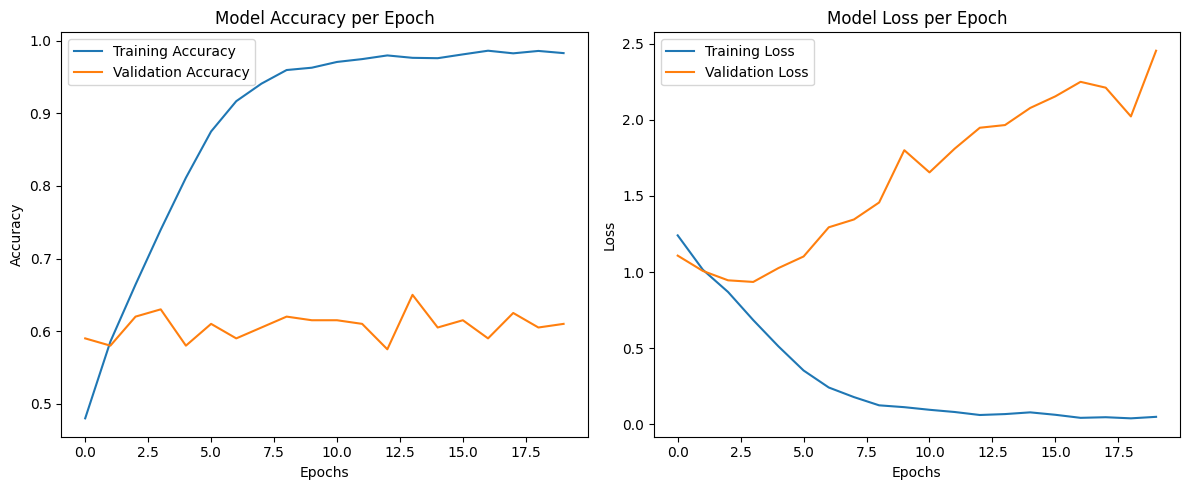

In [12]:

# Plot ulang
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(log_data['accuracy'], label='Training Accuracy')
plt.plot(log_data['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(log_data['loss'], label='Training Loss')
plt.plot(log_data['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## (TIDAK PERLU DI RUNNING LAGI) Kode dibawah hanya untuk kasus jika belum pernah Training sama sekali, Load by History, sedangkan kode diatas untuk Load by Log


In [ ]:
# # ---------------------------------------
# # Plotting model performance: Accuracy and Loss
# # ---------------------------------------
# plt.figure(figsize=(12, 5))

# # Plotting Accuracy over epochs
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy per Epoch')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# # Plotting Loss over epochs
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss per Epoch')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()

# Part 6 - Metrics and evaluation

In [ ]:
# # ---------------------------------------
# # Predictions on the validation set
# # ---------------------------------------
# # Get true and predicted labels
# val_generator.reset()
# preds = model.predict(val_generator, verbose=1)
# y_pred = np.argmax(preds, axis=1)
# y_true = val_generator.classes

# # Get class names
# class_labels = list(val_generator.class_indices.keys())

# # ---------------------------------------
# # Confusion matrix
# # ---------------------------------------

# from sklearn.metrics import confusion_matrix, classification_report

# cm = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
# plt.title('Confusion Matrix - Validation')
# plt.xlabel('Predicted Class')
# plt.ylabel('True Class')
# plt.show()

# # ---------------------------------------
# # Classification Report
# # ---------------------------------------
# print("\nClassification Report:\n")
# print(classification_report(y_true, y_pred, target_names=class_labels))

In [13]:
# ---------------------------------------
# Predictions on the validation set
# ---------------------------------------
# Get true and predicted labels
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 9s/step


In [14]:
# Get class names
class_labels = list(val_generator.class_indices.keys())

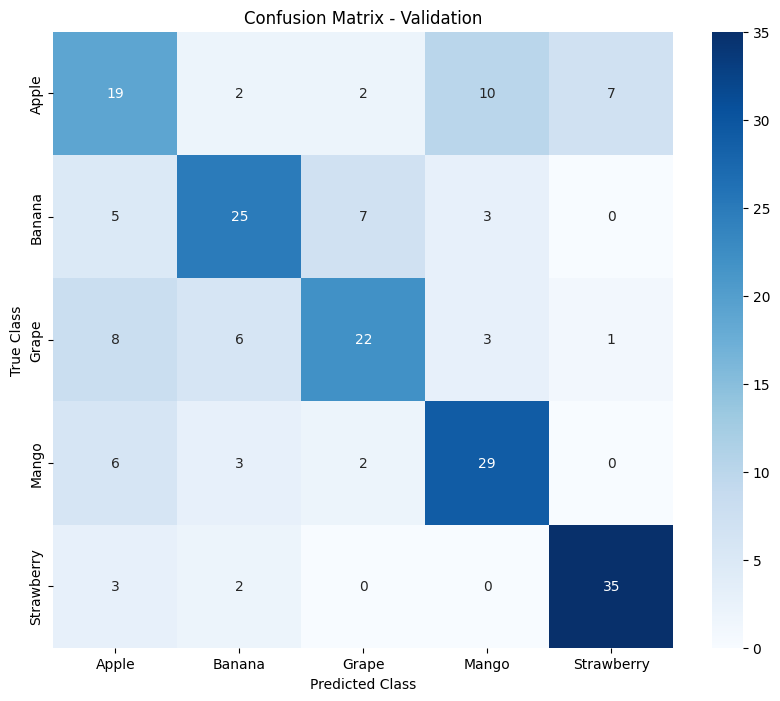

In [15]:
# ---------------------------------------
# Confusion matrix
# ---------------------------------------

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Validation')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [16]:
# ---------------------------------------
# Classification Report
# ---------------------------------------
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:

              precision    recall  f1-score   support

       Apple       0.46      0.47      0.47        40
      Banana       0.66      0.62      0.64        40
       Grape       0.67      0.55      0.60        40
       Mango       0.64      0.72      0.68        40
  Strawberry       0.81      0.88      0.84        40

    accuracy                           0.65       200
   macro avg       0.65      0.65      0.65       200
weighted avg       0.65      0.65      0.65       200



# Part 7 - Preview images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


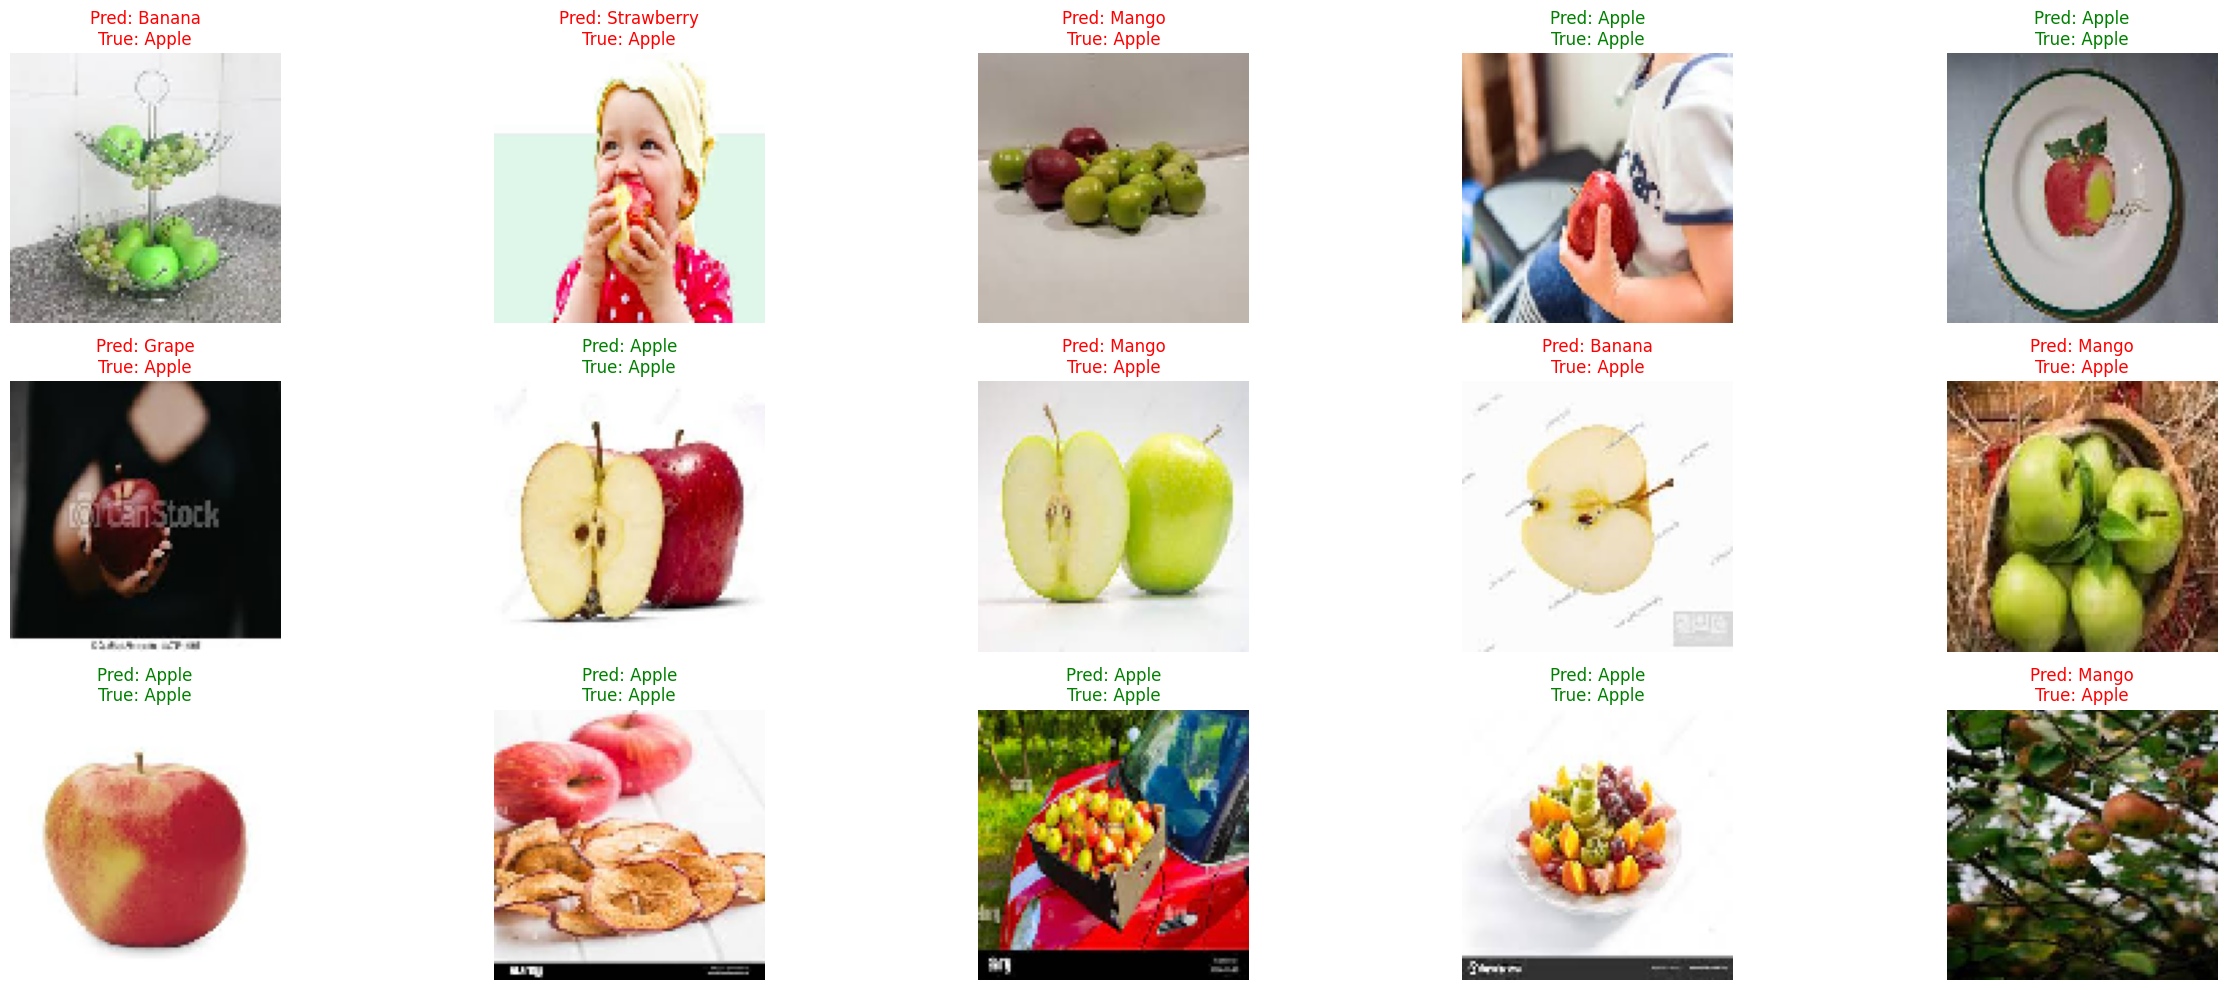

In [17]:
# Classes
class_names = list(val_generator.class_indices.keys())

# Number of images to display
num_images = 15

# Get the first images and labels
val_generator.reset()
images, labels = next(val_generator)

# -----------------------------
# Get images from val_generator properly
# -----------------------------
val_generator.reset()
images, labels = next(val_generator)

# If labels are in one-hot, convert to integer class
if labels.ndim == 2:
    labels = np.argmax(labels, axis=1)

# Prediction
preds = model.predict(images)
predicted_classes = np.argmax(preds, axis=1)

# -----------------------------
# Visualization
# -----------------------------
plt.figure(figsize=(25.5, 10))
num_images = 15

for i in range(num_images):
    plt.subplot(3, 5, i + 1)
    # images[i] is already in range 0-1, convert to 0-255 just for display if desired:
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.axis('off')

    pred_label = class_names[predicted_classes[i]]
    true_label = class_names[labels[i]]

    color = 'green' if predicted_classes[i] == labels[i] else 'red'
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=color)

plt.tight_layout()
plt.show()

In [18]:
# Classes
class_names = list(val_generator.class_indices.keys())

# Number of images to display
num_images = 15

# Get the first images and labels
val_generator.reset()
images, labels = next(val_generator)

In [19]:
# -----------------------------
# Get images from val_generator properly
# -----------------------------
val_generator.reset()
images, labels = next(val_generator)

# If labels are in one-hot, convert to integer class
if labels.ndim == 2:
    labels = np.argmax(labels, axis=1)

# Prediction
preds = model.predict(images)
predicted_classes = np.argmax(preds, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


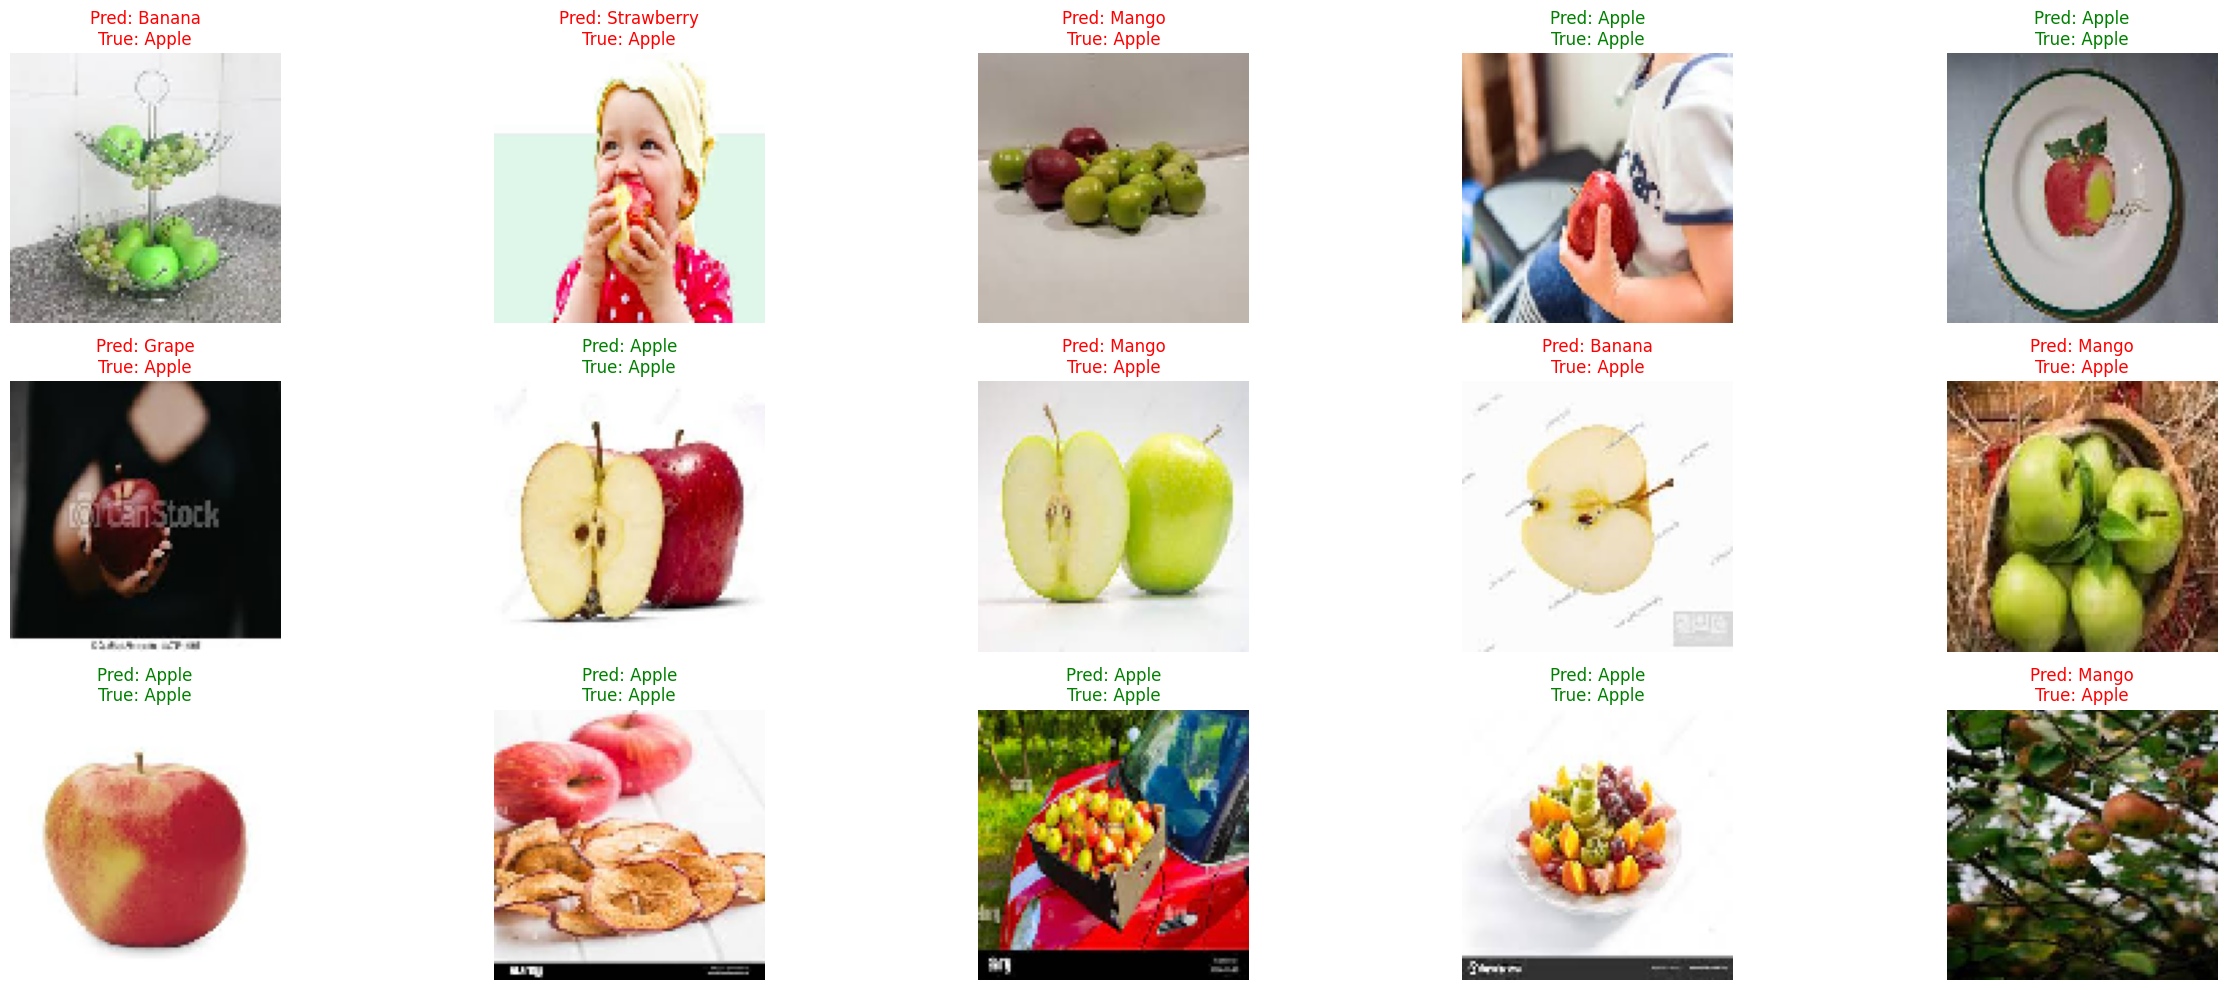

In [20]:
# -----------------------------
# Visualization
# -----------------------------
plt.figure(figsize=(25.5, 10))
num_images = 15

for i in range(num_images):
    plt.subplot(3, 5, i + 1)
    # images[i] is already in range 0-1, convert to 0-255 just for display if desired:
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.axis('off')

    pred_label = class_names[predicted_classes[i]]
    true_label = class_names[labels[i]]

    color = 'green' if predicted_classes[i] == labels[i] else 'red'
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=color)

plt.tight_layout()
plt.show()

# Part 8 - Convolutional Neural Network CNN 2

In [21]:
import os

print(os.listdir('/content/drive/MyDrive/PPP/Buah Tropis/fruits_data'))  # atau lokasi kamu ekstrak zip-nya


['Fruits Classification']


In [ ]:
# # Correct paths
# train_dir = '/content/fruits_data/Fruits Classification/train'
# test_dir = '/content/fruits_data/Fruits Classification/test'
# val_dir = '/content/fruits_data/Fruits Classification/valid'

In [22]:
# Correct paths
base_path = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification'

train_dir = f'{base_path}/train'
test_dir = f'{base_path}/test'
val_dir = f'{base_path}/valid'

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 224, 224
batch_size = 32

# ---------------------------------------
# Data Augmentation (somente para treino)
# ---------------------------------------
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validação e teste: só normalização
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# ---------------------------------------
# Geradores
# ---------------------------------------

# Treino (com augmentation)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # <- corrigido
    shuffle=True
)

# Validação (sem augmentation)
val_generator = val_datagen.flow_from_directory(
    val_dir,                     # <- verifique se a variável é val_dir
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Teste (sem labels)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode=None,
    shuffle=False
)

# ---------------------------------------
# Informações úteis
# ---------------------------------------
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
input_shape = (img_height, img_width, 3)

print(f'Número de classes (treino): {train_generator.num_classes}')
print(f'Amostras no teste:          {test_generator.samples}')

Found 9700 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Número de classes (treino): 5
Amostras no teste:          100


In [24]:
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential

# -----------------------------
# Model functions
# -----------------------------
def build_mobilenet():
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False
    model = Sequential([base_model,
                        GlobalAveragePooling2D(),
                        Dense(128, activation='relu'),
                        Dense(num_classes, activation='softmax')])
    return model

def build_resnet50():
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False
    model = Sequential([base_model,
                        GlobalAveragePooling2D(),
                        Dense(128, activation='relu'),
                        Dense(num_classes, activation='softmax')])
    return model

def build_efficientnet():
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False
    model = Sequential([base_model,
                        GlobalAveragePooling2D(),
                        Dense(128, activation='relu'),
                        Dense(num_classes, activation='softmax')])
    return model

def build_custom_cnn():
    model = Sequential([Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
                        MaxPooling2D((2,2)),
                        Conv2D(128, (3,3), activation='relu'),
                        MaxPooling2D((2,2)),
                        Conv2D(256, (3,3), activation='relu'),
                        MaxPooling2D((2,2)),
                        Flatten(),
                        Dense(256, activation='relu'),
                        Dropout(0.5),
                        Dense(num_classes, activation='softmax')])
    return model

# LOAD ULANG (JIKA SEBELUMNYA SUDAH TRAINING)

Cek Berapa Epoch dari file CSV yang Sudah Dilalui Sebelumnya di Drive folder Logs



In [25]:
import os
import pandas as pd

# Daftar file log CSV
log_files = {
    'Custom_CNN': 'training_log.csv',
    'MobileNetV2': 'training_log_MobileNetV2.csv',
    'ResNet50': 'training_log_ResNet50.csv'
}

# Path dasar folder log
base_log_path = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/logs'

# Baca dan laporkan status masing-masing log
for model_name, filename in log_files.items():
    log_path = os.path.join(base_log_path, filename)

    if os.path.exists(log_path):
        try:
            log_df = pd.read_csv(log_path)
            last_epoch = log_df.shape[0]
            print(f"✅ {model_name}: Log ditemukan – sudah sampai epoch ke-{last_epoch}")
        except Exception as e:
            print(f"❌ {model_name}: Gagal membaca CSV - {e}")
    else:
        print(f"❌ {model_name}: Log file tidak ditemukan - {filename}")


✅ Custom_CNN: Log ditemukan – sudah sampai epoch ke-20
✅ MobileNetV2: Log ditemukan – sudah sampai epoch ke-30
✅ ResNet50: Log ditemukan – sudah sampai epoch ke-30


In [26]:
import os
from tensorflow.keras.models import load_model

# Daftar model yang ingin dimuat (nama file tanpa ekstensi)
model_files = {
    'Custom_CNN_Best': 'best_model.h5',
    'Custom_CNN_Final': 'final_model.h5',
    'MobileNetV2_Best': 'best_model_MobileNetV2.h5',
    'MobileNetV2_Final': 'final_model_MobileNetV2.h5',
    'ResNet50_Best': 'best_model_ResNet50_V3.h5'
}

# Path dasar folder model
base_path = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models'

# Dictionary untuk menyimpan model yang berhasil dimuat
loaded_models = {}

for name, filename in model_files.items():
    model_path = os.path.join(base_path, filename)

    if os.path.exists(model_path):
        try:
            model = load_model(model_path)
            loaded_models[name] = model
            print(f"✅ {name}: Berhasil dimuat dari {filename}")
        except Exception as e:
            print(f"❌ {name}: Gagal load model - {e}")
    else:
        print(f"❌ {name}: File tidak ditemukan - {filename}")


✅ Custom_CNN_Best: Berhasil dimuat dari best_model.h5


✅ Custom_CNN_Final: Berhasil dimuat dari final_model.h5


✅ MobileNetV2_Best: Berhasil dimuat dari best_model_MobileNetV2.h5


✅ MobileNetV2_Final: Berhasil dimuat dari final_model_MobileNetV2.h5


✅ ResNet50_Best: Berhasil dimuat dari best_model_ResNet50_V3.h5


# Melanjutkan Training sebelumnya pada Model "best_model_ResNet50.h5"

In [27]:
import pandas as pd

log_path = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/logs/training_log_ResNet50.csv'
log_df = pd.read_csv(log_path)
print(log_df.tail())  # Lihat 5 epoch terakhir
print(f"Total epoch sebelumnya: {log_df.shape[0]}")


    epoch  accuracy      loss  val_accuracy  val_loss
25     25  0.397938  1.406425         0.410  1.431315
26     26  0.393608  1.406291         0.430  1.394187
27     27  0.400309  1.402779         0.385  1.417637
28     28  0.402371  1.399798         0.445  1.402264
29     29  0.407835  1.392547         0.435  1.411556
Total epoch sebelumnya: 30


Training Tahap 3

In [ ]:
# import os
# import pandas as pd
# from tensorflow.keras.models import load_model
# from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

# # === 1. Path model dan file log ===
# model_path = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/best_model_ResNet50_V2.h5'
# log_path = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/logs/training_log_ResNet50.csv'

# # === 2. Load model V2 (sudah mencapai epoch 29) ===
# if os.path.exists(model_path):
#     print("✅ Model V2 ditemukan, memuat model...")
#     model = load_model(model_path)
# else:
#     raise FileNotFoundError("❌ Model V2 tidak ditemukan. Cek path-nya!")

# # === 3. Compile ulang model (WAJIB) ===
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # === 4. Lanjutkan dari epoch ke-29 ===
# initial_epoch = 29
# target_epoch = 30  # total akhir

# # === 5. Setup logger dan checkpoint ===
# csv_logger = CSVLogger(log_path, append=True)

# checkpoint = ModelCheckpoint(
#     '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/best_model_ResNet50_V3.h5',
#     monitor='val_accuracy',
#     save_best_only=True,
#     verbose=1
# )

# # === 6. Lanjutkan training ===
# history = model.fit(
#     train_generator,
#     initial_epoch=initial_epoch,
#     epochs=target_epoch,
#     validation_data=val_generator,
#     callbacks=[csv_logger, checkpoint]
# )

# # === 7. Simpan model final versi terbaru
# model.save('/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/final_model_ResNet50_V3.h5')


In [28]:
import pandas as pd

log_path = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/logs/training_log.csv'
log_df = pd.read_csv(log_path)
print(log_df.tail())  # Lihat 5 epoch terakhir
print(f"Total epoch sebelumnya: {log_df.shape[0]}")


    epoch  accuracy      loss  val_accuracy  val_loss
15     15  0.981134  0.062491         0.615  2.153986
16     16  0.986186  0.042473         0.590  2.249261
17     17  0.982577  0.046515         0.625  2.210880
18     18  0.985876  0.039157         0.605  2.022067
19     19  0.982887  0.049035         0.610  2.453605
Total epoch sebelumnya: 20


In [29]:
import pandas as pd

log_path = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/logs/training_log_MobileNetV2.csv'
log_df = pd.read_csv(log_path)
print(log_df.tail())  # Lihat 5 epoch terakhir
print(f"Total epoch sebelumnya: {log_df.shape[0]}")


    epoch  accuracy      loss  val_accuracy  val_loss
25     25  0.951959  0.133470         0.890  0.412971
26     26  0.952577  0.131796         0.885  0.413435
27     27  0.954948  0.127565         0.870  0.441537
28     28  0.958557  0.118464         0.900  0.349329
29     29  0.954433  0.132650         0.885  0.432390
Total epoch sebelumnya: 30


In [30]:
import pandas as pd

log_path = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/logs/training_log_ResNet50.csv'
log_df = pd.read_csv(log_path)
print(log_df.tail())  # Lihat 5 epoch terakhir
print(f"Total epoch sebelumnya: {log_df.shape[0]}")


    epoch  accuracy      loss  val_accuracy  val_loss
25     25  0.397938  1.406425         0.410  1.431315
26     26  0.393608  1.406291         0.430  1.394187
27     27  0.400309  1.402779         0.385  1.417637
28     28  0.402371  1.399798         0.445  1.402264
29     29  0.407835  1.392547         0.435  1.411556
Total epoch sebelumnya: 30


# (Tidak Perlu dirunning) code di bawah

In [ ]:
# import os
# from tensorflow.keras.models import load_model
# from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
# import pandas as pd

# # === 1. Path model dan log
# model_path = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/best_model_ResNet50_V2.h5'
# log_path = '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/logs/training_log_ResNet50.csv'

# # === 2. Cek dan load model
# if os.path.exists(model_path):
#     print("✅ Model ResNet50 ditemukan dan siap dilanjutkan.")
#     model = load_model(model_path)
# else:
#     raise FileNotFoundError("❌ Model tidak ditemukan, cek path-nya dengan teliti!")

# # === 3. Compile ulang model
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # === 4. Hitung jumlah epoch sebelumnya dengan pengecekan isi file
# if os.path.exists(log_path) and os.path.getsize(log_path) > 0:
#     log_df = pd.read_csv(log_path)
#     initial_epoch = log_df.shape[0]
#     print(f"📊 Training sebelumnya berhenti di epoch ke-{initial_epoch}")
# else:
#     initial_epoch = 0
#     print("⚠️ Log belum ada atau kosong. Training dimulai dari awal.")


# # === 5. Setup logging dan checkpoint baru
# csv_logger = CSVLogger(log_path, append=True)

# checkpoint = ModelCheckpoint(
#     '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/best_model_ResNet50_V3.h5',
#     monitor='val_accuracy',
#     save_best_only=True,
#     verbose=1
# )

# # === 6. Lanjutkan training
# history = model.fit(
#     train_generator,
#     initial_epoch=initial_epoch,
#     epochs=30,  # Target total epoch
#     validation_data=val_generator,
#     callbacks=[csv_logger, checkpoint]
# )

# # === 7. Simpan model final
# model.save('/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/final_model_ResNet50_V3.h5')


# (Tidak Perlu DIrunning )KODE DI BAWAH JIKA SUDAH PERNAH TRAINING ATAU SUDAH PUNYA FILE LOG NYA

In [ ]:
# %%time

# import os
# from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

# # Pastikan folder ada
# os.makedirs(f'{base_path}/logs', exist_ok=True)
# os.makedirs(f'{base_path}/models', exist_ok=True)



# # -----------------------------
# # Model list
# # -----------------------------
# models = {
#     'MobileNetV2': build_mobilenet,
#     'ResNet50': build_resnet50,
#     'EfficientNetB0': build_efficientnet,
#     'Custom_CNN': build_custom_cnn
# }

# # -----------------------------
# # Training and evaluation loop
# # -----------------------------
# results = {}

# for name, build_fn in models.items():
#     print(f"\n{'='*30}\nTraining model: {name}\n{'='*30}")

#     model = build_fn()
#     model.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

#     # Buat path khusus untuk model ini
#     log_path = f'{base_path}/logs/training_log_{name}.csv'
#     best_model_path = f'{base_path}/models/best_model_{name}.h5'
#     final_model_path = f'{base_path}/models/final_model_{name}.h5'

#     # Setup callback
#     csv_logger = CSVLogger(log_path, append=True)
#     checkpoint = ModelCheckpoint(
#         best_model_path,
#         monitor='val_accuracy',
#         save_best_only=True,
#         verbose=1
#     )

#     # Train model
#     history = model.fit(
#         train_generator,
#         epochs=30,
#         validation_data=val_generator,
#         callbacks=[csv_logger, checkpoint]
#     )

#     # Simpan model akhir
#     model.save(final_model_path)

#     # Simpan history-nya
#     results[name] = history



Training model: MobileNetV2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7143 - loss: 0.7551
Epoch 1: val_accuracy improved from -inf to 0.88000, saving model to /content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/best_model_MobileNetV2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 579s 2s/step - accuracy: 0.7145 - loss: 0.7546 - val_accuracy: 0.8800 - val_loss: 0.4129
Epoch 2/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8424 - loss: 0.4287
Epoch 2: val_accuracy improved from 0.88000 to 0.88500, saving model to /content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/best_model_MobileNetV2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 566s 2s/step - accuracy: 0.8424 - loss: 0.4286 - val_accuracy: 0.8850 - val_loss: 0.3788
Epoch 3/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8598 - loss: 0.3870
Epoch 3: val_accuracy improved from 0.88500 to 0.91000, saving model to /content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/best_model_MobileNetV2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 631s 2s/step - accuracy: 0.8598 - loss: 0.3869 - val_accuracy: 0.9100 - val_loss: 0.3471
Epoch 4/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8709 - loss: 0.3565
Epoch 4: val_accuracy did not improve from 0.91000
304/304 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.8709 - loss: 0.3565 - val_accuracy: 0.8850 - val_loss: 0.3537
Epoch 5/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8869 - loss: 0.3136
Epoch 5: val_accuracy did not improve from 0.91000
304/304 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - accuracy: 0.8868 - loss: 0.3136 - val_accuracy: 0.8850 - val_loss: 0.3649
Epoch 6/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8892 - loss: 0.3022
Epoch 6: val_accuracy did not improve from 0.91000
304/304 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - accuracy: 0.8892 - loss: 0.3022 - val_accuracy: 0.8900 - val_loss: 0.3159
Epoch 7/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8948 - loss: 0.2821
Epoch 7: val_accuracy did not impro

304/304 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step - accuracy: 0.9063 - loss: 0.2590 - val_accuracy: 0.9250 - val_loss: 0.2821
Epoch 10/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9132 - loss: 0.2285
Epoch 10: val_accuracy did not improve from 0.92500
304/304 ━━━━━━━━━━━━━━━━━━━━ 573s 2s/step - accuracy: 0.9132 - loss: 0.2286 - val_accuracy: 0.9050 - val_loss: 0.3090
Epoch 11/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9173 - loss: 0.2347
Epoch 11: val_accuracy did not improve from 0.92500
304/304 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.9173 - loss: 0.2347 - val_accuracy: 0.9000 - val_loss: 0.3035
Epoch 12/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9189 - loss: 0.2133
Epoch 12: val_accuracy did not improve from 0.92500
304/304 ━━━━━━━━━━━━━━━━━━━━ 574s 2s/step - accuracy: 0.9189 - loss: 0.2134 - val_accuracy: 0.8800 - val_loss: 0.3020
Epoch 13/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9270 - loss: 0.1974
Epoch 13: val_accuracy did n


Training model: ResNet50
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2461 - loss: 1.6463
Epoch 1: val_accuracy improved from -inf to 0.23500, saving model to /content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/best_model_ResNet50.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 1807s 6s/step - accuracy: 0.2461 - loss: 1.6462 - val_accuracy: 0.2350 - val_loss: 1.5858
Epoch 2/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2983 - loss: 1.5621
Epoch 2: val_accuracy improved from 0.23500 to 0.35000, saving model to /content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/best_model_ResNet50.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 1821s 6s/step - accuracy: 0.2983 - loss: 1.5621 - val_accuracy: 0.3500 - val_loss: 1.5241
Epoch 3/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2985 - loss: 1.5361
Epoch 3: val_accuracy did not improve from 0.35000
304/304 ━━━━━━━━━━━━━━━━━━━━ 1780s 6s/step - accuracy: 0.2985 - loss: 1.5361 - val_accuracy: 0.3300 - val_loss: 1.5318
Epoch 4/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3228 - loss: 1.5262
Epoch 4: val_accuracy did not improve from 0.35000
304/304 ━━━━━━━━━━━━━━━━━━━━ 1787s 6s/step - accuracy: 0.3228 - loss: 1.5262 - val_accuracy: 0.3000 - val_loss: 1.5801
Epoch 5/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3149 - loss: 1.5370
Epoch 5: val_accuracy improved from 0.35000 to 0.38000, saving model to /content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/best_model_ResNet50.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 1816s 6s/step - accuracy: 0.3150 - loss: 1.5369 - val_accuracy: 0.3800 - val_loss: 1.4826
Epoch 6/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3246 - loss: 1.5146
Epoch 6: val_accuracy did not improve from 0.38000
304/304 ━━━━━━━━━━━━━━━━━━━━ 1806s 6s/step - accuracy: 0.3246 - loss: 1.5146 - val_accuracy: 0.2950 - val_loss: 1.5671
Epoch 7/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3297 - loss: 1.5125
Epoch 7: val_accuracy did not improve from 0.38000
304/304 ━━━━━━━━━━━━━━━━━━━━ 1798s 6s/step - accuracy: 0.3297 - loss: 1.5125 - val_accuracy: 0.3700 - val_loss: 1.4778
Epoch 8/30
 74/304 ━━━━━━━━━━━━━━━━━━━━ 22:33 6s/step - accuracy: 0.3181 - loss: 1.5109

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/train/Strawberry/Strawberry (1025).jpeg'
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 248, in _finite_generator
    yield self._standardize_batch(self.py_dataset[i])
                                  ~~~~~~~~~~~~~~~^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(
          ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/image_utils.py", line 235, in load_img
    with open(path, "rb") as f:
         ^^^^^^^^^^^^^^^^

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/train/Strawberry/Strawberry (1025).jpeg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_274095]

In [ ]:
# %%time

# # -----------------------------
# # Model list
# # -----------------------------
# models = {'MobileNetV2': build_mobilenet,
#           'ResNet50': build_resnet50,
#           'EfficientNetB0': build_efficientnet,
#           'Custom_CNN': build_custom_cnn}

# # -----------------------------
# # Training and evaluation loop
# # -----------------------------
# results = {}

# for name, build_fn in models.items():
#     print(f"\n{'='*30}\nTraining model: {name}\n{'='*30}")
#     model = build_fn()
#     model.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

#     history = model.fit(train_generator,
#                         epochs=30,
#                         validation_data=val_generator)

#     results[name] = history


Training model: MobileNetV2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 565s 2s/step - accuracy: 0.7056 - loss: 0.7670 - val_accuracy: 0.8200 - val_loss: 0.5098
Epoch 2/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 557s 2s/step - accuracy: 0.8428 - loss: 0.4370 - val_accuracy: 0.8600 - val_loss: 0.3939
Epoch 3/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.8564 - loss: 0.3890 - val_accuracy: 0.8650 - val_loss: 0.3767
Epoch 4/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 564s 2s/step - accuracy: 0.8840 - loss: 0.3289 - val_accuracy: 0.9000 - val_loss: 0.3174
Epoch 5/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 563s 2s/step - accuracy: 0.8898 - loss: 0.3138 - val_accuracy: 0.8750 - val_loss: 0.3604
Epoch 6/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 566s 2s/step - accuracy: 0.8812 - loss: 0.3113 - val_accuracy: 0.8650 - val_loss: 0.3458
Epoch 7/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 557s 2s/step - accuracy: 0.8990 - loss: 0.2884 - val_accuracy: 0.8800 - val_loss: 0.3244
Epoch 8/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 557s 2s/step - accuracy: 0.9046 - loss: 0.2609 - val_accu

## (Running kode di bawah Ini) versi Load Data Log CSV

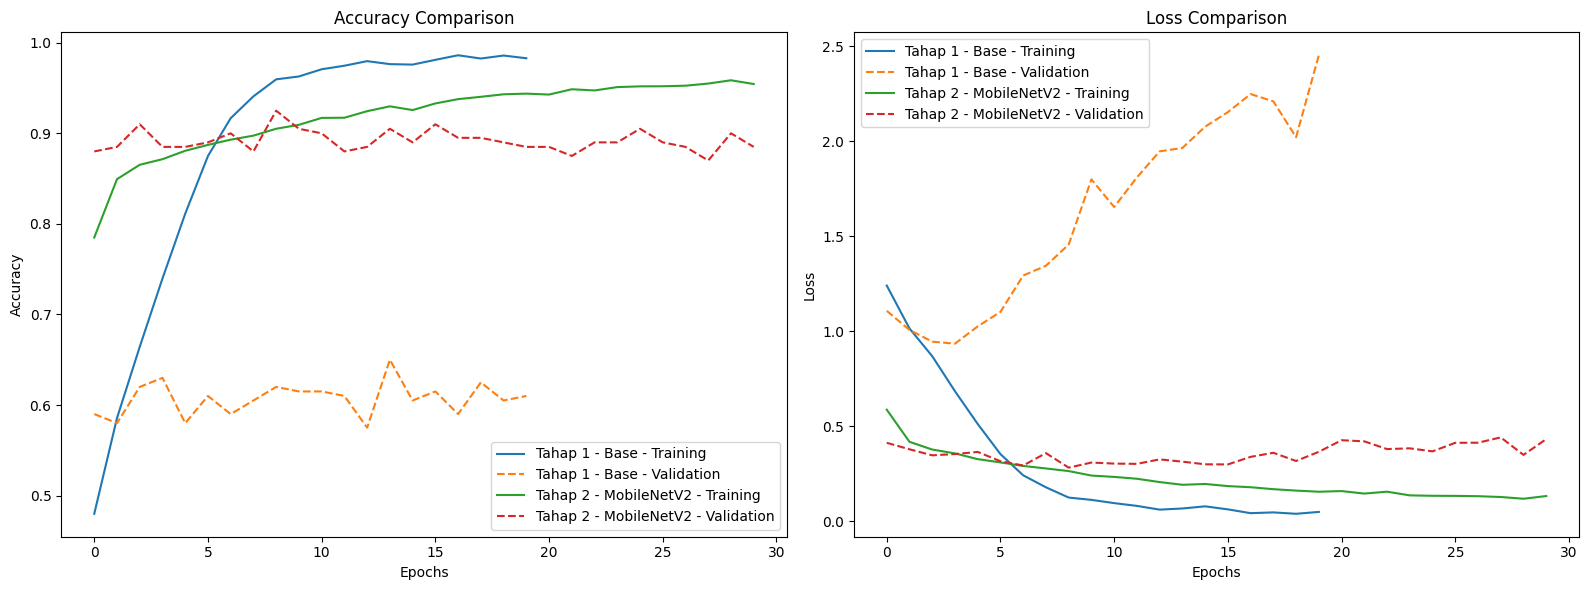

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

def load_log_csv(path):
    df = pd.read_csv(path)
    return {
        'accuracy': df['accuracy'].values,
        'val_accuracy': df['val_accuracy'].values,
        'loss': df['loss'].values,
        'val_loss': df['val_loss'].values
    }

# Muat log ke dictionary (hanya Tahap 1 dan 2)
results_from_logs = {
    'Tahap 1 - Base': load_log_csv('/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/logs/training_log.csv'),
    'Tahap 2 - MobileNetV2': load_log_csv('/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/logs/training_log_MobileNetV2.csv')
}

# Fungsi untuk mem-plot performa model
def plot_model_performance(results):
    plt.figure(figsize=(16, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    for name, log_data in results.items():
        plt.plot(log_data['accuracy'], label=f'{name} - Training')
        plt.plot(log_data['val_accuracy'], linestyle='--', label=f'{name} - Validation')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for name, log_data in results.items():
        plt.plot(log_data['loss'], label=f'{name} - Training')
        plt.plot(log_data['val_loss'], linestyle='--', label=f'{name} - Validation')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Jalankan plot
plot_model_performance(results_from_logs)


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# def load_log_csv(path):
#     df = pd.read_csv(path)
#     return {
#         'accuracy': df['accuracy'].values,
#         'val_accuracy': df['val_accuracy'].values,
#         'loss': df['loss'].values,
#         'val_loss': df['val_loss'].values
#     }

# # Muat semua log ke dictionary
# results_from_logs = {
#     'Tahap 1 - Base': load_log_csv('/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/logs/training_log.csv'),
#     'Tahap 2 - MobileNetV2': load_log_csv('/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/logs/training_log_MobileNetV2.csv'),
#     'Tahap 3 - ResNet50': load_log_csv('/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/logs/training_log_ResNet50.csv')
# }

# # Gunakan fungsi yang sudah kamu buat:
# def plot_model_performance(results):
#     plt.figure(figsize=(16, 6))

#     # Accuracy
#     plt.subplot(1, 2, 1)
#     for name, log_data in results.items():
#         plt.plot(log_data['accuracy'], label=f'{name} - Training')
#         plt.plot(log_data['val_accuracy'], linestyle='--', label=f'{name} - Validation')
#     plt.title('Accuracy Comparison')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     # Loss
#     plt.subplot(1, 2, 2)
#     for name, log_data in results.items():
#         plt.plot(log_data['loss'], label=f'{name} - Training')
#         plt.plot(log_data['val_loss'], linestyle='--', label=f'{name} - Validation')
#     plt.title('Loss Comparison')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# # Jalankan plot
# plot_model_performance(results_from_logs)


# (Jangan Running kode di bawah Ini) versi Load Data History

In [ ]:
# # ----------------------------------------
# # Plot comparison function
# # ----------------------------------------
# def plot_model_performance(results):
#     plt.figure(figsize=(16, 6))

#     # Accuracy
#     plt.subplot(1, 2, 1)
#     for name, history in results.items():
#         plt.plot(history.history['accuracy'], label=f'{name} - Training')
#         plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{name} - Validation')
#     plt.title('Accuracy Comparison')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     # Loss
#     plt.subplot(1, 2, 2)
#     for name, history in results.items():
#         plt.plot(history.history['loss'], label=f'{name} - Training')
#         plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} - Validation')
#     plt.title('Loss Comparison')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# # ----------------------------------------
# # Execute comparison plot
# # ----------------------------------------
# plot_model_performance(results)

# (Running kode di bawah Ini) versi Load Data Model PKL


Memproses model: MobileNetV2_FRUIT
Model MobileNetV2_FRUIT ditemukan di Drive, memuat model dan melanjutkan training dari epoch ke-10...


Model MobileNetV2_FRUIT sudah selesai dilatih sampai epoch ke-10. Tidak perlu training ulang.
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


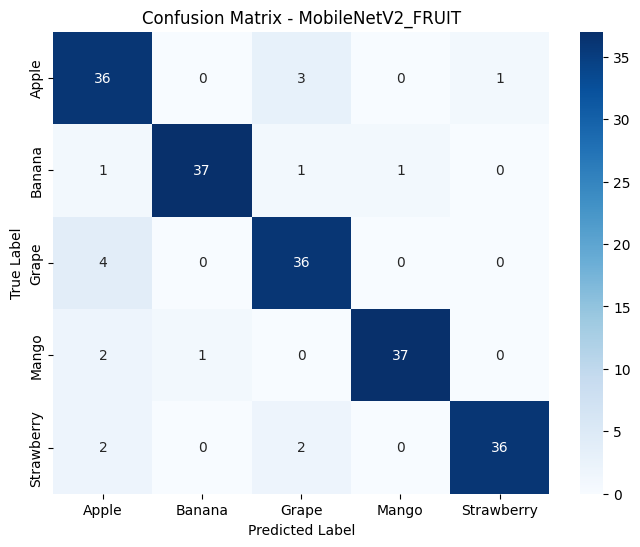


Classification Report untuk MobileNetV2_FRUIT:

              precision    recall  f1-score   support

       Apple       0.80      0.90      0.85        40
      Banana       0.97      0.93      0.95        40
       Grape       0.86      0.90      0.88        40
       Mango       0.97      0.93      0.95        40
  Strawberry       0.97      0.90      0.94        40

    accuracy                           0.91       200
   macro avg       0.92      0.91      0.91       200
weighted avg       0.92      0.91      0.91       200


Memproses model: ResNet50_FRUIT
Model ResNet50_FRUIT ditemukan di Drive, memuat model dan melanjutkan training dari epoch ke-10...


Model ResNet50_FRUIT sudah selesai dilatih sampai epoch ke-10. Tidak perlu training ulang.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


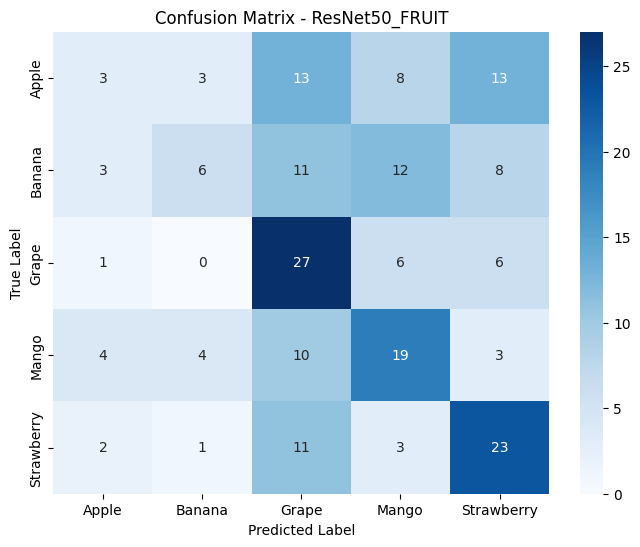


Classification Report untuk ResNet50_FRUIT:

              precision    recall  f1-score   support

       Apple       0.23      0.07      0.11        40
      Banana       0.43      0.15      0.22        40
       Grape       0.38      0.68      0.48        40
       Mango       0.40      0.47      0.43        40
  Strawberry       0.43      0.57      0.49        40

    accuracy                           0.39       200
   macro avg       0.37      0.39      0.35       200
weighted avg       0.37      0.39      0.35       200



In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

# Nama kelas dan parameter umum
class_names = list(val_generator.class_indices.keys())
num_classes = len(class_names)
input_shape = (224, 224, 3)
base_save_dir = "/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/ModelHasil/"

# ---------------------------------------------
# Fungsi pembuat model
# ---------------------------------------------
def build_mobilenetv2_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions)

def build_resnet50_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions)

# ---------------------------------------------
# Model dictionary
# ---------------------------------------------
model_dict = {
    'MobileNetV2_FRUIT': build_mobilenetv2_model,
    'ResNet50_FRUIT': build_resnet50_model
}

max_epochs = 10
results = {}

for name, build_fn in model_dict.items():
    print(f"\n{'='*30}\nMemproses model: {name}\n{'='*30}")

    model_save_dir = os.path.join(base_save_dir, f"{name}_Model")
    os.makedirs(model_save_dir, exist_ok=True)

    model_path = os.path.join(model_save_dir, f"{name}.h5")
    history_path = os.path.join(model_save_dir, f"{name}_history.pkl")
    epoch_path = os.path.join(model_save_dir, f"{name}_last_epoch.txt")

    # Load last epoch
    if os.path.exists(epoch_path):
        with open(epoch_path, 'r') as f:
            initial_epoch = int(f.read())
    else:
        initial_epoch = 0

    if os.path.exists(model_path):
        print(f"Model {name} ditemukan di Drive, memuat model dan melanjutkan training dari epoch ke-{initial_epoch}...")
        model = load_model(model_path)
        if os.path.exists(history_path):
            with open(history_path, 'rb') as f:
                history = pickle.load(f)
        else:
            history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    else:
        print(f"Model {name} tidak ditemukan, membuat model baru dan mulai training dari awal...")
        model = build_fn()
        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
        initial_epoch = 0

    # Callback untuk simpan model terbaik
    checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

    # Callback untuk simpan epoch terakhir ke file
    def on_epoch_end(epoch, logs):
        with open(epoch_path, 'w') as f:
            f.write(str(epoch + 1))
        # Update history
        for k, v in logs.items():
            if k in history:
                history[k].append(v)
            else:
                history[k] = [v]

    save_epoch_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    if initial_epoch >= max_epochs:
        print(f"Model {name} sudah selesai dilatih sampai epoch ke-{max_epochs}. Tidak perlu training ulang.")
    else:
        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        history_fit = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=max_epochs,
            initial_epoch=initial_epoch,
            callbacks=[checkpoint, save_epoch_callback],
            verbose=1
        )

        # Gabungkan history lama dengan baru
        for key in history_fit.history:
            if key in history:
                history[key].extend(history_fit.history[key])
            else:
                history[key] = history_fit.history[key]

        with open(history_path, 'wb') as f:
            pickle.dump(history, f)

        results[name] = history

    # ----------------------------------------
    # Evaluasi Model
    # ----------------------------------------
    y_pred = []
    y_true = []

    for images, labels in val_generator:
        preds = model.predict(images)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(labels, axis=1))
        if len(y_pred) >= val_generator.samples:
            break

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print(f"\nClassification Report untuk {name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))


###Lihat Grafik Training vs Validation Accuracy dan Loss


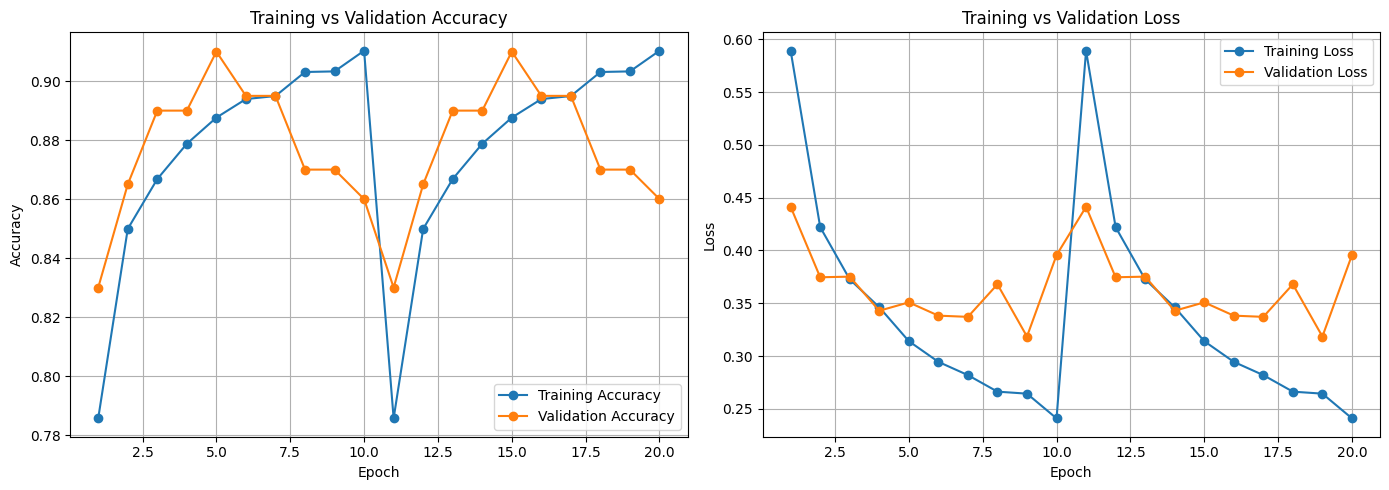

In [40]:
import pickle
import matplotlib.pyplot as plt

# Path ke file history
history_path = "/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/ModelHasil/MobileNetV2_FRUIT_Model/MobileNetV2_FRUIT_history.pkl"

# Muat history dari file pkl
with open(history_path, 'rb') as f:
    history = pickle.load(f)

# Fungsi untuk menampilkan grafik Learning Curve
def plot_learning_curves(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Grafik Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Grafik Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Tampilkan grafik
plot_learning_curves(history)


## (OPSIONAL) Hapus File Test yang Rusak

In [44]:
import os
from PIL import Image

# Lokasi folder test
test_dir = "/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/test"

# Fungsi untuk mendeteksi file rusak
def remove_corrupted_images(directory):
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            fpath = os.path.join(class_dir, fname)
            try:
                with Image.open(fpath) as img:
                    img.verify()  # Cek validitas gambar
            except Exception as e:
                print(f"❌ Menghapus file rusak: {fpath} | Error: {e}")
                os.remove(fpath)

# Jalankan pembersihan
remove_corrupted_images(test_dir)


❌ Menghapus file rusak: /content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/test/Apple/Apple (27).jpeg | Error: cannot identify image file '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/test/Apple/Apple (27).jpeg'
❌ Menghapus file rusak: /content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/test/Apple/Apple (1415).jpeg | Error: cannot identify image file '/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/test/Apple/Apple (1415).jpeg'


## Lihat Akurasi Uji & Loss (Training)

In [46]:
import pickle

# Path ke history training
history_path = "/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/ModelHasil/MobileNetV2_FRUIT_Model/MobileNetV2_FRUIT_history.pkl"

# Load history
with open(history_path, 'rb') as f:
    history = pickle.load(f)

# Ambil akurasi training & validasi dari epoch terakhir
final_train_acc = history['accuracy'][-1]
final_val_acc = history['val_accuracy'][-1]

print(f"Akurasi Training Terakhir     : {final_train_acc:.4f}")
print(f"Akurasi Validasi Terakhir    : {final_val_acc:.4f}")


Akurasi Training Terakhir     : 0.9103
Akurasi Validasi Terakhir    : 0.8600


## Lihat Akurasi Uji & Loss (Testing)

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Path
model_path = "/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/ModelHasil/MobileNetV2_FRUIT_Model/MobileNetV2_FRUIT.h5"
test_dir = "/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/test"

# Generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load dan compile ulang model
model = load_model(model_path)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluasi ulang
loss, accuracy = model.evaluate(test_generator, verbose=1)
print(f"Akurasi Uji  : {accuracy:.4f}")
print(f"Loss Uji     : {loss:.4f}")


Found 98 images belonging to 5 classes.


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 868ms/step - accuracy: 0.8905 - loss: 0.2497
Akurasi Uji  : 0.8878
Loss Uji     : 0.2584


## Lihat/cek jumlah data training dan testing

In [47]:
# Jumlah data per kelas di training
print("Data Training per kelas:")
for kelas, jumlah in train_generator.class_indices.items():
    count = len(train_generator.filepaths) - sum([1 for path in train_generator.filepaths if kelas not in path])
    print(f"  {kelas}: {count} file")

# Jumlah data per kelas di testing
print("\nData Testing per kelas:")
for kelas, jumlah in test_generator.class_indices.items():
    count = len(test_generator.filepaths) - sum([1 for path in test_generator.filepaths if kelas not in path])
    print(f"  {kelas}: {count} file")


Data Training per kelas:
  Apple: 1940 file
  Banana: 1940 file
  Grape: 1940 file
  Mango: 1940 file
  Strawberry: 1940 file

Data Testing per kelas:
  Apple: 18 file
  Banana: 20 file
  Grape: 20 file
  Mango: 20 file
  Strawberry: 20 file


# (Jangan Running kode di bawah)

In [ ]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pickle

# from sklearn.metrics import confusion_matrix, classification_report
# from tensorflow.keras.models import load_model
# from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback
# from tensorflow.keras.applications import MobileNetV2, ResNet50
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
# from tensorflow.keras.optimizers import Adam

# # Nama kelas dan parameter umum
# class_names = list(val_generator.class_indices.keys())
# num_classes = len(class_names)
# input_shape = (224, 224, 3)
# save_dir = "/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/ModelHasil/"

# # Pastikan folder penyimpanan ada
# os.makedirs(save_dir, exist_ok=True)

# # ---------------------------------------------
# # Fungsi pembuat model
# # ---------------------------------------------
# def build_mobilenetv2_model():
#     base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
#     base_model.trainable = False
#     x = GlobalAveragePooling2D()(base_model.output)
#     x = Dense(128, activation='relu')(x)
#     predictions = Dense(num_classes, activation='softmax')(x)
#     return Model(inputs=base_model.input, outputs=predictions)

# def build_resnet50_model():
#     base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
#     base_model.trainable = False
#     x = GlobalAveragePooling2D()(base_model.output)
#     x = Dense(128, activation='relu')(x)
#     predictions = Dense(num_classes, activation='softmax')(x)
#     return Model(inputs=base_model.input, outputs=predictions)

# # ---------------------------------------------
# # Model dictionary
# # ---------------------------------------------
# model_dict = {
#     'MobileNetV2_FRUIT': build_mobilenetv2_model,
#     'ResNet50_FRUIT': build_resnet50_model
# }

# max_epochs = 10
# results = {}

# for name, build_fn in model_dict.items():
#     print(f"\n{'='*30}\nMemproses model: {name}\n{'='*30}")
#     model_path = os.path.join(save_dir, f"{name}.h5")
#     history_path = os.path.join(save_dir, f"{name}_history.pkl")
#     epoch_path = os.path.join(save_dir, f"{name}_last_epoch.txt")

#     # Load last epoch
#     if os.path.exists(epoch_path):
#         with open(epoch_path, 'r') as f:
#             initial_epoch = int(f.read())
#     else:
#         initial_epoch = 0

#     if os.path.exists(model_path):
#         print(f"Model {name} ditemukan di Drive, memuat model dan melanjutkan training dari epoch ke-{initial_epoch}...")
#         model = load_model(model_path)
#         if os.path.exists(history_path):
#             with open(history_path, 'rb') as f:
#                 history = pickle.load(f)
#         else:
#             history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
#     else:
#         print(f"Model {name} tidak ditemukan, membuat model baru dan mulai training dari awal...")
#         model = build_fn()
#         model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
#         history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
#         initial_epoch = 0

#     # Callback untuk simpan model terbaik
#     checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

#     # Callback untuk simpan epoch terakhir ke file
#     def on_epoch_end(epoch, logs):
#         with open(epoch_path, 'w') as f:
#             f.write(str(epoch + 1))
#         # Update history
#         for k, v in logs.items():
#             if k in history:
#                 history[k].append(v)
#             else:
#                 history[k] = [v]

#     save_epoch_callback = LambdaCallback(on_epoch_end=on_epoch_end)

#     # Kalau sudah selesai training sebelumnya
#     if initial_epoch >= max_epochs:
#         print(f"Model {name} sudah selesai dilatih sampai epoch ke-{max_epochs}. Tidak perlu training ulang.")
#     else:
#         model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
#         history_fit = model.fit(
#             train_generator,
#             validation_data=val_generator,
#             epochs=max_epochs,
#             initial_epoch=initial_epoch,
#             callbacks=[checkpoint, save_epoch_callback],
#             verbose=1
#         )

#         # Gabungkan history baru dengan history lama
#         for key in history_fit.history:
#             if key in history:
#                 history[key].extend(history_fit.history[key])
#             else:
#                 history[key] = history_fit.history[key]

#         # Simpan history
#         with open(history_path, 'wb') as f:
#             pickle.dump(history, f)

#         results[name] = history

#     # ----------------------------------------
#     # Evaluasi Model
#     # ----------------------------------------
#     y_pred = []
#     y_true = []

#     for images, labels in val_generator:
#         preds = model.predict(images)
#         y_pred.extend(np.argmax(preds, axis=1))
#         y_true.extend(np.argmax(labels, axis=1))
#         if len(y_pred) >= val_generator.samples:
#             break

#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=class_names,
#                 yticklabels=class_names)
#     plt.title(f'Confusion Matrix - {name}')
#     plt.ylabel('True Label')
#     plt.xlabel('Predicted Label')
#     plt.show()

#     print(f"\nClassification Report untuk {name}:\n")
#     print(classification_report(y_true, y_pred, target_names=class_names))


# (Jangan Running kode di bawah Ini) Blm Optimal

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, classification_report

# from tensorflow.keras.applications import MobileNetV2, ResNet50
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
# from tensorflow.keras.optimizers import Adam

# # Ambil nama kelas dari val_generator
# class_names = list(val_generator.class_indices.keys())
# num_classes = len(class_names)
# input_shape = (224, 224, 3)  # Sesuaikan dengan data kamu

# # ---------------------------------------------
# # Fungsi pembuat model
# # ---------------------------------------------
# def build_mobilenetv2_model():
#     base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
#     base_model.trainable = False  # Freeze base model (optional)
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(128, activation='relu')(x)
#     predictions = Dense(num_classes, activation='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=predictions)
#     return model

# def build_resnet50_model():
#     base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
#     base_model.trainable = False  # Freeze base model (optional)
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(128, activation='relu')(x)
#     predictions = Dense(num_classes, activation='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=predictions)
#     return model

# # ---------------------------------------------
# # Dictionary model & Training Loop
# # ---------------------------------------------
# model_dict = {
#     'MobileNetV2': build_mobilenetv2_model,
#     'ResNet50': build_resnet50_model
# }

# results = {}

# for name, build_fn in model_dict.items():
#     print(f"\n{'='*30}\nTraining model: {name}\n{'='*30}")

#     model = build_fn()
#     model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

#     history = model.fit(
#         train_generator,
#         validation_data=val_generator,
#         epochs=10,
#         verbose=1
#     )

#     results[name] = history

#     # Prediksi
#     y_pred = []
#     y_true = []

#     for images, labels in val_generator:
#         preds = model.predict(images)
#         y_pred.extend(np.argmax(preds, axis=1))
#         y_true.extend(np.argmax(labels, axis=1))
#         if len(y_pred) >= val_generator.samples:
#             break

#     # Confusion Matrix
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=class_names,
#                 yticklabels=class_names)
#     plt.title(f'Confusion Matrix - {name}')
#     plt.ylabel('True Label')
#     plt.xlabel('Predicted Label')
#     plt.show()

#     # Classification Report
#     print(f"\nClassification Report for {name}:\n")
#     print(classification_report(y_true, y_pred, target_names=class_names))


# (Jangan Running kode di bawah Ini) versi Load Data History

In [ ]:
# from sklearn.metrics import classification_report

# ## Loop over all models
# for name, build_fn in models.items():
#     print(f"\n{'='*30}\nTraining model: {name}\n{'='*30}")

#     ## Build and compile the model
#     model = build_fn()
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     ## Store training history
#     results[name] = history

#     ## ----------------------------------------
#     ## Inference on validation set
#     ## ----------------------------------------
#     y_pred = []
#     y_true = []

#     ## Loop over batches from val_generator
#     for images, labels in val_generator:
#         preds = model.predict(images)
#         preds_classes = np.argmax(preds, axis=1)
#         true_classes = np.argmax(labels, axis=1)  ## Convert One-Hot to class indices

#         y_pred.extend(preds_classes)
#         y_true.extend(true_classes)

#         ## Stop after all validation samples are predicted
#         if len(y_pred) >= val_generator.samples:
#             break

#     ## ----------------------------------------
#     ## Confusion Matrix
#     ## ----------------------------------------
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=class_names,
#                 yticklabels=class_names)
#     plt.title(f'Confusion Matrix - {name}')
#     plt.ylabel('True Label')
#     plt.xlabel('Predicted Label')
#     plt.show()

# LAST 2 Code

## (Running Kode di bawah) Kode modifikasi dari yang di bawahnya

In [35]:
import os
import numpy as np
import pickle
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# Misalnya: model_dict = {'MobileNetV2_FRUIT': build_mobilenetv2_model, ...}
model_dict = {
    'MobileNetV2_FRUIT': build_mobilenetv2_model,
    'ResNet50_FRUIT': build_resnet50_model
}

base_save_dir = "/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/ModelHasil/"
results = {}

for name, build_fn in model_dict.items():
    print(f"\n{'='*30}\nMemproses model: {name}\n{'='*30}")

    model_path = os.path.join(base_save_dir, f"{name}_Model", f"{name}.h5")
    history_path = os.path.join(base_save_dir, f"{name}_Model", f"{name}_history.pkl")

    # Cek apakah model sudah ada
    if os.path.exists(model_path):
        print(f"📦 Model ditemukan, memuat: {model_path}")
        model = load_model(model_path)
        if os.path.exists(history_path):
            with open(history_path, 'rb') as f:
                history = pickle.load(f)
        else:
            history = {}
    else:
        print(f"🛠 Model belum ada, membuat dan melatih dari awal...")
        model = build_fn()
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=10,
            verbose=1
        ).history

        # Simpan model dan history
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        model.save(model_path)
        with open(history_path, 'wb') as f:
            pickle.dump(history, f)

    results[name] = history

    # Evaluasi
    y_pred, y_true = [], []
    for images, labels in val_generator:
        preds = model.predict(images)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(labels, axis=1))
        if len(y_pred) >= val_generator.samples:
            break

    print(f"\n📊 Classification Report - {name}")
    print(classification_report(y_true, y_pred, target_names=class_names))



Memproses model: MobileNetV2_FRUIT
📦 Model ditemukan, memuat: /content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/ModelHasil/MobileNetV2_FRUIT_Model/MobileNetV2_FRUIT.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

📊 Classification Report - MobileNetV2_FRUIT
              precision    recall  f1-score   support

       Apple       0.80      0.90      0.85        40
      Banana       0.97      0.93      0.95        40
       Grape       0.86      0.90      0.88        40
       Mango       0.97      0.93      0.95        40
  Strawberry       0.97      0.90      0.94        40

    accuracy                           0.91       200
   macro avg       0.92      0.91      0.91       200
weighted avg       0.92      0.91      0.91       200


Memproses model: ResNet50_FRUIT
📦 Model ditemukan, memuat: /content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/ModelHasil/ResNet50_FRUIT_Model/ResNet50_FRUIT.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

📊 Classification Report - ResNet50_FRUIT
              precision    recall  f1-score   support

       Apple       0.23      0.07      0.11        40
      Banana       0.43      0.15      0.22        40
       Grape       0.38      0.68      0.48        40
       Mango       0.40      0.47      0.43        40
  Strawberry       0.43      0.57      0.49        40

    accuracy                           0.39       200
   macro avg       0.37      0.39      0.35       200
weighted avg       0.37      0.39      0.35       200



## (Jangan Running Kode di bawah) Malah Training Ulang BABI ↓

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np

# # Ganti `models` dengan dictionary yang berisi model builder function
# # Misal: model_dict = {'MobileNetV2': build_mobilenetv2_model, ...}

# # Misal kamu pakai ini:
# # model_dict = {
# #     'MobileNetV2': build_mobilenetv2_model,
# #     'ResNet50': build_resnet50_model
# # }

# model_dict = {
#     'MobileNetV2_FRUIT': build_mobilenetv2_model,
#     'ResNet50_FRUIT': build_resnet50_model
# }

# results = {}

# # Loop over all models
# for name, build_fn in model_dict.items():
#     print(f"\n{'='*30}\nTraining model: {name}\n{'='*30}")

#     # Build and compile the model
#     model = build_fn()
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     # Train model (tanpa callbacks untuk versi ini)
#     history = model.fit(
#         train_generator,
#         validation_data=val_generator,
#         epochs=10,
#         verbose=1
#     )

#     # Store training history
#     results[name] = history.history

#     # ----------------------------------------
#     # Inference on validation set
#     # ----------------------------------------
#     y_pred = []
#     y_true = []

#     # Loop over batches from val_generator
#     for images, labels in val_generator:
#         preds = model.predict(images)
#         preds_classes = np.argmax(preds, axis=1)
#         true_classes = np.argmax(labels, axis=1)  # Convert One-Hot to class indices

#         y_pred.extend(preds_classes)
#         y_true.extend(true_classes)

#         # Stop when all validation samples are processed
#         if len(y_pred) >= val_generator.samples:
#             break

#     # ----------------------------------------
#     # Classification Report
#     # ----------------------------------------
#     print(f"\nClassification Report - {name}")
#     print(classification_report(y_true, y_pred, target_names=class_names))


## (Jangan Running Kode di bawah) Kode Default ↓

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix


# # Loop over all models
# for name, build_fn in models.items():
#     print(f"\n{'='*30}\nTraining model: {name}\n{'='*30}")

#     # Build and compile the model
#     model = build_fn()
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     # Store training history
#     results[name] = history

#     # ----------------------------------------
#     # Inference on validation set
#     # ----------------------------------------
#     y_pred = []
#     y_true = []

#     # Loop over batches from val_generator
#     for images, labels in val_generator:
#         preds = model.predict(images)
#         preds_classes = np.argmax(preds, axis=1)
#         true_classes = np.argmax(labels, axis=1)  # Convert One-Hot to class indices

#         y_pred.extend(preds_classes)
#         y_true.extend(true_classes)

#         # Stop when all validation samples are processed
#         if len(y_pred) >= val_generator.samples:
#             break

#     # ----------------------------------------
#     # Classification Report
#     # ----------------------------------------
#     print(f"\nClassification Report - {name}")
#     print(classification_report(y_true, y_pred, target_names=class_names))

# (Running Kode di bawah ini) FIX


Predictions - MobileNetV2_FRUIT


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


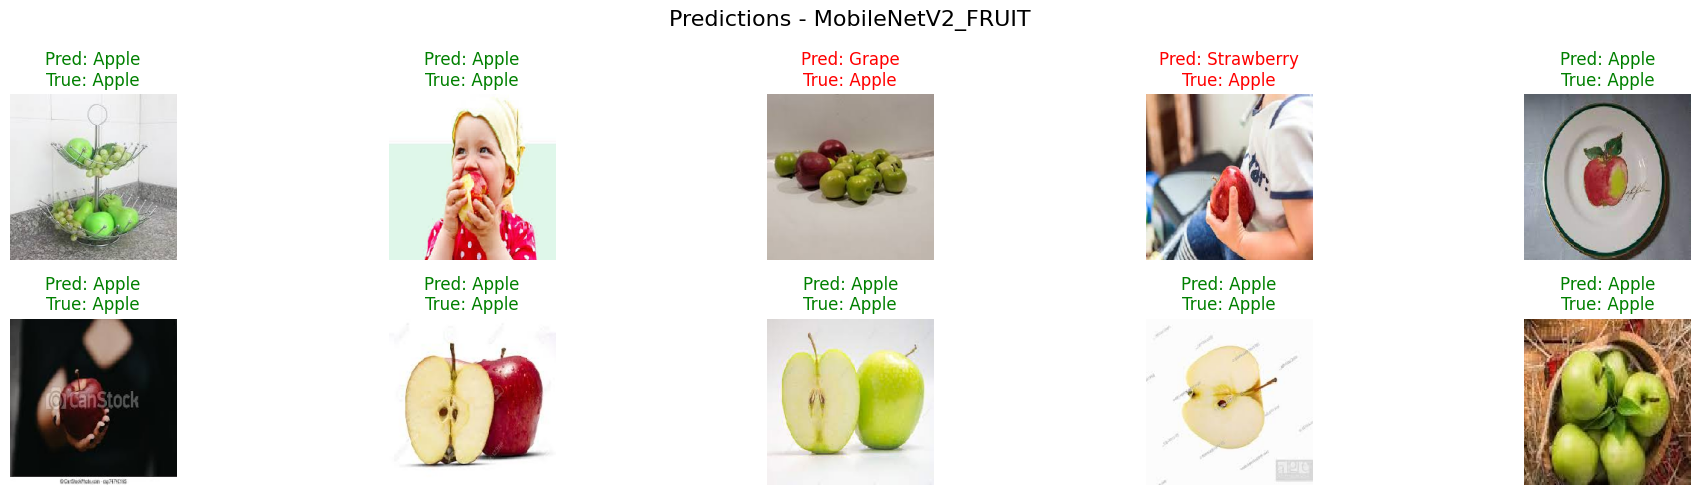


Predictions - ResNet50_FRUIT


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


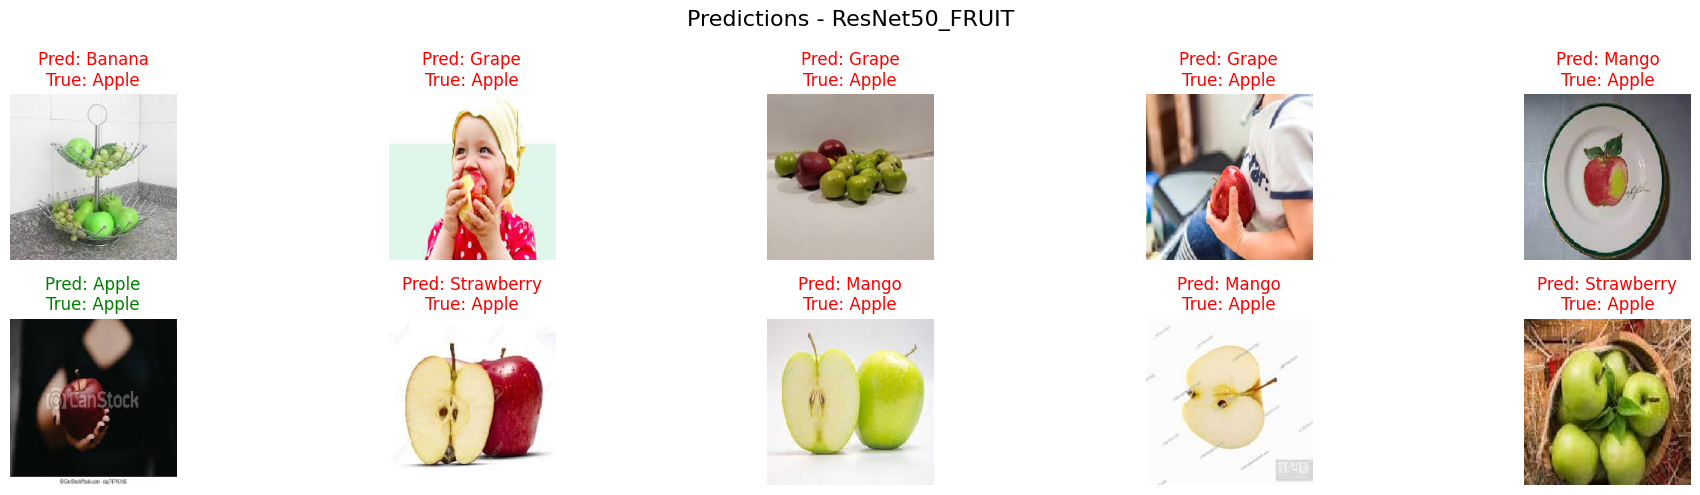

In [36]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

# Jumlah gambar yang ingin ditampilkan
num_images = 10

# Ambil satu batch dari validation generator
images_batch, labels_batch = next(val_generator)

# Jika label masih one-hot, ubah ke indeks kelas
if labels_batch.ndim == 2:
    labels_batch = np.argmax(labels_batch, axis=1)

# Dictionary model yang akan dipakai
model_names = ['MobileNetV2_FRUIT', 'ResNet50_FRUIT']

for name in model_names:
    print(f"\n{'='*30}\nPredictions - {name}\n{'='*30}")

    # Path ke model yang sudah disimpan
    model_path = f"/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/ModelHasil/{name}_Model/{name}.h5"

    # Load model dari file
    model = load_model(model_path)

    # Prediksi batch gambar
    preds = model.predict(images_batch)
    predicted_classes = np.argmax(preds, axis=1)

    # Tampilkan gambar dengan prediksi dan label asli
    plt.figure(figsize=(20, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i+1)
        plt.imshow((images_batch[i] * 255).astype("uint8"))
        plt.axis('off')
        pred_label = class_names[predicted_classes[i]]
        true_label = class_names[labels_batch[i]]
        color = 'green' if predicted_classes[i] == labels_batch[i] else 'red'
        plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=color)

    plt.suptitle(f'Predictions - {name}', fontsize=16)
    plt.tight_layout()
    plt.show()


# (Jangan Running Kode di bawah) Kode default ↓

In [ ]:
# # Number of images to be displayed
# num_images = 10

# # Get one batch from the validation generator
# images_batch, labels_batch = next(val_generator)

# # If labels are in one-hot encoding, convert them to class indices
# if labels_batch.ndim == 2:
#     labels_batch = np.argmax(labels_batch, axis=1)

# # Loop for each trained model
# for name, build_fn in models.items():
#     print(f"\n{'='*30}\nPredictions - {name}\n{'='*30}")

#     # Rebuild the model (note: in ideal case, you should store the trained model and avoid retraining here)
#     model = build_fn()
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     # Make predictions on the batch
#     preds = model.predict(images_batch)
#     predicted_classes = np.argmax(preds, axis=1)

#     # Display images with predicted and true labels
#     plt.figure(figsize=(20, 5))
#     for i in range(num_images):
#         plt.subplot(2, 5, i+1)
#         plt.imshow((images_batch[i] * 255).astype("uint8"))
#         plt.axis('off')
#         pred_label = class_names[predicted_classes[i]]
#         true_label = class_names[labels_batch[i]]
#         color = 'green' if predicted_classes[i] == labels_batch[i] else 'red'
#         plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=color)

#     plt.suptitle(f'Predictions - {name}', fontsize=16)
#     plt.tight_layout()
#     plt.show()

# UI GUI (GRADIO)

## (Jangan Running jika sudah pernah install Gradio) Kode Instalasi

In [37]:
!pip install -q gradio


## UI Klasifikasi gambar buah

# (Jangan di-Running) GUI GAGAL

In [ ]:
# # ========== IMPORT ========== #
# import gradio as gr
# import numpy as np
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing import image
# from PIL import Image

# # ========== KONFIGURASI ========== #
# # Path ke model H5 hasil training
# model_path = "/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/ModelHasil/MobileNetV2_FRUIT_Model/MobileNetV2_FRUIT.h5"

# # Daftar kelas (ganti sesuai dataset)
# class_names = ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']

# # Load model
# print("\u23F3 Loading model...")
# model = load_model(model_path)
# print("\u2705 Model loaded!")

# # ========== FUNGSI PREDIKSI ========== #
# def classify_image(img: Image.Image):
#     # Resize gambar ke 224x224 (ubah jika ukuran input model berbeda)
#     img_resized = img.resize((224, 224))

#     # Convert ke array & normalisasi
#     img_array = image.img_to_array(img_resized) / 255.0
#     img_batch = np.expand_dims(img_array, axis=0)

#     # Prediksi
#     preds = model.predict(img_batch)[0]
#     top_class_idx = np.argmax(preds)
#     top_class_name = class_names[top_class_idx]

#     # Buat dictionary probabilitas
#     probs_dict = {class_names[i]: float(preds[i]) for i in range(len(class_names))}

#     return top_class_name, probs_dict

# # ========== UI GRADIO ========== #
# interface = gr.Interface(
#     fn=classify_image,
#     inputs=gr.Image(type="pil", label="Upload Gambar Buah"),
#     outputs=[
#         gr.Label(label="Prediksi Buah"),
#         gr.BarPlot(label="Probabilitas Kelas")
#     ],
#     title="Klasifikasi Buah Tropis",
#     description="Upload gambar buah tropis, dan model akan memprediksi jenisnya.",
#     theme=gr.themes.Soft()
# )

# # ========== LAUNCH ========== #
# interface.launch(share=True, debug=True)


# DONE (GUI Ver 1)

In [38]:
import gradio as gr
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import register_keras_serializable

# 1. Daftarkan fungsi custom (jika diperlukan oleh model Anda)
@register_keras_serializable()
def resize_image(x):
    return tf.image.resize(x, [224, 224])

# 2. Load model Anda
model = load_model("/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/ModelHasil/MobileNetV2_FRUIT_Model/MobileNetV2_FRUIT.h5",
                   custom_objects={"resize_image": resize_image})

# 3. Label buah Anda (Sudah benar!)
class_labels = [
    "Apple",
    "Banana",
    "Grape",
    "Mango",
    "Strawberry"
]

# 4. Fungsi prediksi yang sudah diperbaiki
def predict_fruit(image):
    # --- PERBAIKAN 1: Proses gambar sebagai RGB (berwarna) ---
    # Baris "ImageOps.grayscale(image)" telah DIHAPUS.

    # Ubah ukuran gambar agar sesuai dengan input model
    image = image.resize((224, 224))

    # Konversi gambar ke array dan normalisasi
    image_array = np.array(image) / 255.0

    # --- PERBAIKAN 2: Reshape array agar sesuai dengan input model ---
    # Ukuran menjadi (1, 224, 224, 3) untuk 1 gambar, ukuran 224x224, dan 3 channel warna (RGB)
    image_array = image_array.reshape(1, 224, 224, 3)

    # Lakukan prediksi
    prediction = model.predict(image_array)

    # Dapatkan hasil prediksi dalam bentuk dictionary {label: confidence}
    confidences = {class_labels[i]: float(prediction[0][i]) for i in range(len(class_labels))}

    return confidences

# 5. Buat antarmuka Gradio yang sudah diperbaiki
iface = gr.Interface(
    fn=predict_fruit,
    # --- PERBAIKAN 1: Terima input gambar berwarna (RGB) ---
    inputs=gr.Image(type="pil", image_mode="RGB", label="Unggah Gambar Buah"),
    # Gunakan komponen Label untuk output yang lebih bagus
    outputs=gr.Label(num_top_classes=5),
    title="Klasifikasi 5 Jenis Buah",
    description="Unggah gambar buah (Apel, Pisang, Anggur, Mangga, Stroberi) dan lihat hasil prediksinya.",
    examples=[
        ["apple_test.jpg"],
        ["banana_test.jpg"],
        ["mango_test.jpg"],
        ["grape_test.jpg"],
        ["strawberry_test.jpg"]
    ]
)

# Jalankan aplikasi
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e0f44faa82c0eb0bd4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# DONE (GUI Ver 2)

In [39]:
# ========== IMPORT ========== #
import gradio as gr
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import register_keras_serializable

# ========== REGISTER CUSTOM OBJECT (JIKA PERLU) ========== #
@register_keras_serializable()
def resize_image(x):
    return tf.image.resize(x, [224, 224])

# ========== KONFIGURASI MODEL ========== #
model_path = "/content/drive/MyDrive/PPP/Buah Tropis/fruits_data/Fruits Classification/models/ModelHasil/MobileNetV2_FRUIT_Model/MobileNetV2_FRUIT.h5"

# Load model (pastikan path dan custom_objects sesuai)
print("⏳ Loading model...")
model = load_model(model_path, custom_objects={"resize_image": resize_image})
print("✅ Model loaded!")

# Daftar kelas (ganti jika label kamu berbeda)
class_labels = ["Apple", "Banana", "Grape", "Mango", "Strawberry"]

# ========== FUNGSI PREDIKSI ========== #
def predict_fruit(image: Image.Image):
    # Resize ke input model (224x224)
    image = image.resize((224, 224))

    # Ubah ke array dan normalisasi
    image_array = np.array(image) / 255.0

    # Pastikan bentuk input (1, 224, 224, 3)
    image_array = image_array.reshape(1, 224, 224, 3)

    # Prediksi
    prediction = model.predict(image_array)[0]

    # Hasil prediksi dalam bentuk dictionary
    confidences = {class_labels[i]: float(prediction[i]) for i in range(len(class_labels))}

    return confidences

# ========== UI GRADIO ========== #
iface = gr.Interface(
    fn=predict_fruit,
    inputs=gr.Image(type="pil", image_mode="RGB", label="Upload Gambar Buah"),
    outputs=gr.Label(num_top_classes=5),
    title="Klasifikasi 5 Jenis Buah Tropis",
    description="Unggah gambar buah (Apel, Pisang, Anggur, Mangga, Stroberi), dan model akan memprediksi jenis buah tersebut.",
    examples=[
        ["/content/apple_test.jpg"],
        ["/content/banana_test.jpg"],
        ["/content/mango_test.jpg"],
        ["/content/grape_test.jpg"],
        ["/content/strawberry_test.jpg"]
    ],
    theme=gr.themes.Soft()
)

# ========== LAUNCH ========== #
iface.launch(share=True)


⏳ Loading model...


✅ Model loaded!
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fa8c27389d0eac9240.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
